## **Retail Price Prediction and Optimization Using Regression Trees and Bootstrapping** <br>
By: Ruiz Lorenzo B. Chavez, John Allen C. Caballa, Alyanna Marrielle C. Gammad, Jo-Anne April P. Mejia, Ria Juvica M. Panugan <br>
DATA103 - S11 T2 A.Y. 2022-2023

### **Problem Statement** <br>
It has been known that price optimization has always been constrained as compared in the present times (Simchi-Levi, 2017). Business owners tend to have a hard time deciding the right price to compete amongst its competitors to intrigue its target customers. Moreover, if products are priced wrongfully, it can cause a huge drawback for the business as it would affect customer attraction and have lower leverage for its competitions. However, with the increasing availability of wide data, it has now been accessible and easier to have prices optimized at a right level (Simchi-Levi, 2017).
<br>
<br>
With the advances of technology and machine learning, it has been feasible enough to have price optimization utilized in a bigger sense (Simchi-Levi, 2017). Its relevance lies within the opportunity of businesses to have an optimum price point to increase their profits and possibly customer satisfaction due to products priced enough. Thus, being able to have price optimization allows a competitive advantage in pricing to ultimately reach the business’ goals (Intelligence Node, n.d.). That being said, we aim to develop a retail price prediction and otpimization model by utilizing regression trees and bootstrapping.


### **Data Collection** <br>
For this project, the Brazilian e-commerce public dataset retrieved from [Kaggle](www.kaggle.com/datasets/olistbr/brazilian-ecommerce) will be used. This dataset was created by the Brazilian company, Olist, from actual transactions on their online store. The data was retrieved between 2016-2018, covering a total of 100k unique transactions. Features for this dataset are neatly divided by theme across separate sub datasets, which are linked by its respective foreign keys. Any issues regarding possibly sensitive information have already been dealt with by Olist; all customer names and brands featured in the dataset have been anonymized before then.Overall the information provided in this dataset is rather comprehensive, with a mix of textual, numerical, and geospatial data. 

Below is a table summarizing the features that can be found in the dataset with its equivalent descriptions:


### *olist_products_dataset*

| column | type | dtype | description |
|--------|-------|----|----------|
| product_id | 
| product_category_name |
| product_name_length |
| product_description_length |
| product_description_length |
| prodduct_photos_qty |
| product_length_cm |
| product_height_cm |
| product_width_cm |


*description of each feature taken from Kaggle*

### *product_trans_df*

| column | type | dtype | description |
|--------|-------|----|----------|
| product_category_name | 
| product_category_name_english |


*description of each feature taken from Kaggle*

### *olist_orders_dataset*

| column | type | dtype | description |
|--------|-------|----|----------|
| order_id | 
| order_item_id |
| product_id |
| shipping_limit_date |
| price |


*description of each feature taken from Kaggle*

### *olist_order_items_dataset*

| column | type | dtype | description |
|--------|-------|----|----------|
| order_id | 
| order_item_id |
| product_id |
| seller_id |
| shipping_limit_date |
| price |
| fright_value |


*description of each feature taken from Kaggle*

In [471]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import sys
import pydotplus

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from six import StringIO

## Data Preprocessing

### Loading the dataset: Brazilian E-commerce Public Dataset by Olist

In [472]:
#  dataset on product info
products_df = pd.read_csv("data/olist_products_dataset.csv")                    #  shows product information as advertised on the site
product_trans_df = pd.read_csv("data/product_category_name_translation.csv")    #  shows product name translations

#  datasets on orders info 
order_only_df = pd.read_csv("data/olist_orders_dataset.csv",                    #  * MAIN DATASET: shows order transactions 
                            parse_dates=["order_purchase_timestamp",
                                         "order_approved_at",                
                                         "order_delivered_carrier_date",     
                                         "order_delivered_customer_date",    
                                         "order_estimated_delivery_date"])                                   
order_items_df = pd.read_csv("data/olist_order_items_dataset.csv",              #  shows order/product price + shipping fee
                             parse_dates=["shipping_limit_date"])              
order_payments_df = pd.read_csv("data/olist_order_payments_dataset.csv")        #  shows order payment total + method
order_reviews_df = pd.read_csv("data/olist_order_reviews_dataset.csv",          #  shows order reviews (numerical + text)
                               parse_dates=["review_creation_date",
                                            "review_answer_timestamp"])          

#  datasets on customer and seller
customer_df = pd.read_csv("data/olist_customers_dataset.csv")                   #  shows customer info (location)
seller_df = pd.read_csv("data/olist_sellers_dataset.csv")                       #  shows sellenr info (location)

#  dataset on geolocation/coordinates of cities/states in Brazil
geolocation_df = pd.read_csv("data/olist_geolocation_dataset.csv")              #  shows coordinates of locations in Brazil (customer & seller position)

![data schema of Olist dataset](notebook_images/data_schema.png)

In [473]:
df_dict = {
    "products_df": products_df,
    "product_trans_df": product_trans_df,
    "order_only_df": order_only_df,
    "order_items_df": order_items_df,
    "order_payments_df": order_payments_df,
    "order_reviews_df": order_reviews_df,
    "customer_df": customer_df,
    "seller_df": seller_df,
    "geolocation_df": geolocation_df,
    }

for df in df_dict:
    print(f"\n{df}")
    display(df_dict[df].head())


products_df


product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0               30.0               18.0              20.0  
2             154.0               18.0                9.0              15.0  
3             371.0               26.0                4.0              26.0  
4             625.0               20.0               17.0              13.0


product_trans_df


product_category_name product_category_name_english
0            beleza_saude                 health_beauty
1  informatica_acessorios         computers_accessories
2              automotivo                          auto
3         cama_mesa_banho                bed_bath_table
4        moveis_decoracao               furniture_decor


order_only_df


order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  
0                    2017-10-18  
1                    2018-08-13  
2                    2018-09-04  
3                    2017-12-15  
4                    2018-02-26


order_items_df


order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

  shipping_limit_date   price  freight_value  
0 2017-09-19 09:45:35   58.90          13.29  
1 2017-05-03 11:05:13  239.90          19.93  
2 2018-01-18 14:48:30  199.00          17.87  
3 2018-08-15 10:10:18   12.99          12.79  
4 2017-02-13 13:57:51  199.90          18.14


order_payments_df


order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3  ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4  42fdf880ba16b47b59251dd489d4441a                   1  credit_card   

   payment_installments  payment_value  
0                     8          99.33  
1                     1          24.39  
2                     1          65.71  
3                     8         107.78  
4                     2         128.45


order_reviews_df


review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score review_comment_title  \
0             4                  NaN   
1             5                  NaN   
2             5                  NaN   
3             5                  NaN   
4             5                  NaN   

                              review_comment_message review_creation_date  \
0                                                NaN           2018-01-18   
1                                                NaN           2018-03-10   
2                                                NaN           2018-02-17   
3              Recebi bem antes do prazo estipulado.           2017-04-21   
4  Parabéns lojas lannister adorei comprar pela I...           2018-03-01   

  review_answer_timestamp  
0     2018-01-18 21:46:59  
1     2018-03-11 03:05:13  
2     2018-02-18 14:36:24  
3     2017-04-21 22:02:06  
4     2018-03-02 10:26:53


customer_df


customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP


seller_df


seller_id  seller_zip_code_prefix  \
0  3442f8959a84dea7ee197c632cb2df15                   13023   
1  d1b65fc7debc3361ea86b5f14c68d2e2                   13844   
2  ce3ad9de960102d0677a81f5d0bb7b2d                   20031   
3  c0f3eea2e14555b6faeea3dd58c1b1c3                    4195   
4  51a04a8a6bdcb23deccc82b0b80742cf                   12914   

         seller_city seller_state  
0           campinas           SP  
1         mogi guacu           SP  
2     rio de janeiro           RJ  
3          sao paulo           SP  
4  braganca paulista           SP


geolocation_df


geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                         1037       -23.545621       -46.639292   
1                         1046       -23.546081       -46.644820   
2                         1046       -23.546129       -46.642951   
3                         1041       -23.544392       -46.639499   
4                         1035       -23.541578       -46.641607   

  geolocation_city geolocation_state  
0        sao paulo                SP  
1        sao paulo                SP  
2        sao paulo                SP  
3        sao paulo                SP  
4        sao paulo                SP

### Diagnosing the data

#### Shape of each dataset

In [474]:
for df in df_dict:
    row_num, col_num = df_dict[df].shape
    print(f"{df} has {row_num:,} rows and {col_num:,} columns")

products_df has 32,951 rows and 9 columns
product_trans_df has 71 rows and 2 columns
order_only_df has 99,441 rows and 8 columns
order_items_df has 112,650 rows and 7 columns
order_payments_df has 103,886 rows and 5 columns
order_reviews_df has 99,224 rows and 7 columns
customer_df has 99,441 rows and 5 columns
seller_df has 3,095 rows and 4 columns
geolocation_df has 1,000,163 rows and 5 columns


#### Correcting typos in the column of products_df

In [475]:
#  correcting column name 
products_df = products_df.rename(columns={"product_name_lenght": "product_name_length",
                                          "product_description_lenght": "product_description_length"})

#### Merging relevant datasets 

In [476]:
items_shape, transaction_shape, reviews_shape = order_items_df.shape, order_only_df.shape, order_reviews_df.shape
print(f"Merging order_items_df {items_shape}, order_only_df {transaction_shape}, and order_reviews_df {reviews_shape}")

#  left join order_items & order_only to get the most entries
transactions_df = (order_items_df
                   .merge(order_only_df,
                          how="inner",
                          on="order_id")
                   .merge(order_reviews_df,
                          how="inner",
                          on="order_id")
                   )

print(f"transactions_df has {transactions_df.shape}")

Merging order_items_df (112650, 7), order_only_df (99441, 8), and order_reviews_df (99224, 7)
transactions_df has (112372, 20)


In [477]:
products_shape, translation_shape = products_df.shape, product_trans_df.shape
print(f"Merging order_items_df {products_shape} and order_only_df {translation_shape}")

products_df = products_df.merge(product_trans_df,
                                on="product_category_name",
                                how="inner")

products_df = products_df.drop(columns=["product_category_name"])

print(f"products_df has {products_df.shape}")

Merging order_items_df (32951, 9) and order_only_df (71, 2)
products_df has (32328, 9)


In [478]:
transaction_shape, products_shape = transactions_df.shape, products_df.shape
print(f"Merging transaction_df {transaction_shape} and products_df {products_shape}")

transactions_df = transactions_df.merge(products_df,
                                        on="product_id",
                                        how="inner")

print(f"transactions_df has {transactions_df.shape}")
transactions_df.head()

Merging transaction_df (112372, 20) and products_df (32328, 9)
transactions_df has (110750, 28)


order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  130898c0987d1801452a8ed92a670612              1   
2  532ed5e14e24ae1f0d735b91524b98b9              1   
3  6f8c31653edb8c83e1a739408b5ff750              1   
4  7d19f4ef4d04461989632411b7e588b9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
2  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
3  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
4  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   

  shipping_limit_date  price  freight_value                       customer_id  \
0 2017-09-19 09:45:35   58.9          13.29  3ce436f183e68e07877b285a838db11a   
1 2017-07-05 02:44:11   55.9          17.96  e6eecc5a77de221464d1c4eaff0a9b64   
2 2018-05-23 10:56:25   64.9          18.33  4ef55bf80f711b372afebcb7c715344a   
3 2017-08-07 18:55:08   58.9          16.17  30407a72ad8b3f4df4d15369126b20c9   
4 2017-08-16 22:05:11   58.9          13.29  91a792fef70ecd8cc69d3c7feb3d12da   

  order_status order_purchase_timestamp  ... review_creation_date  \
0    delivered      2017-09-13 08:59:02  ...           2017-09-21   
1    delivered      2017-06-28 11:52:20  ...           2017-07-14   
2    delivered      2018-05-18 10:25:53  ...           2018-06-05   
3    delivered      2017-08-01 18:38:42  ...           2017-08-10   
4    delivered      2017-08-10 21:48:40  ...           2017-08-25   

  review_answer_timestamp product_name_length product_description_length  \
0     2017-09-22 10:57:03                58.0                      598.0   
1     2017-07-17 12:50:07                58.0                      598.0   
2     2018-06-06 21:41:12                58.0                      598.0   
3     2017-08-13 03:35:17                58.0                      598.0   
4     2017-08-28 00:51:18                58.0                      598.0   

  product_photos_qty  product_weight_g product_length_cm product_height_cm  \
0                4.0             650.0              28.0               9.0   
1                4.0             650.0              28.0               9.0   
2                4.0             650.0              28.0               9.0   
3                4.0             650.0              28.0               9.0   
4                4.0             650.0              28.0               9.0   

  product_width_cm product_category_name_english  
0             14.0                    cool_stuff  
1             14.0                    cool_stuff  
2             14.0                    cool_stuff  
3             14.0                    cool_stuff  
4             14.0                    cool_stuff  

[5 rows x 28 columns]

#### Checking for null values in the dataset

In [479]:
def column_eval(df) -> pd.DataFrame:
    null_count = df.isna().sum()
    total_rows = df.shape[0]
    percent_null = (null_count / total_rows) * 100
    column_dtypes = df.dtypes
    
    null_dataframe = pd.DataFrame(data={"null_count": null_count,
                                        "percent_null": percent_null,
                                        "dytpes": column_dtypes},
                                  index=df.columns)
    return null_dataframe

transactions_eval = column_eval(transactions_df)
display(transactions_eval)
display(msno.matrix(transactions_df, 
                    figsize=(10,7))
        )

null_count  percent_null          dytpes
order_id                                0      0.000000          object
order_item_id                           0      0.000000           int64
product_id                              0      0.000000          object
seller_id                               0      0.000000          object
shipping_limit_date                     0      0.000000  datetime64[ns]
price                                   0      0.000000         float64
freight_value                           0      0.000000         float64
customer_id                             0      0.000000          object
order_status                            0      0.000000          object
order_purchase_timestamp                0      0.000000  datetime64[ns]
order_approved_at                      14      0.012641  datetime64[ns]
order_delivered_carrier_date         1145      1.033860  datetime64[ns]
order_delivered_customer_date        2293      2.070429  datetime64[ns]
order_estimated_delivery_date           0      0.000000  datetime64[ns]
review_id                               0      0.000000          object
review_score                            0      0.000000           int64
review_comment_title                97403     87.948533          object
review_comment_message              63827     57.631603          object
review_creation_date                    0      0.000000  datetime64[ns]
review_answer_timestamp                 0      0.000000  datetime64[ns]
product_name_length                     0      0.000000         float64
product_description_length              0      0.000000         float64
product_photos_qty                      0      0.000000         float64
product_weight_g                        1      0.000903         float64
product_length_cm                       1      0.000903         float64
product_height_cm                       1      0.000903         float64
product_width_cm                        1      0.000903         float64
product_category_name_english           0      0.000000          object

<Axes: >

##### Dealing with null values

In [480]:
#  remove columns with more than 50% empty values
mostly_null_columns = transactions_eval.query("percent_null > 50").index
transactions_df = transactions_df.drop(columns=mostly_null_columns)

#  remove rows with null values
transactions_df = transactions_df.dropna(axis=0)

display(msno.matrix(transactions_df, 
                    figsize=(10,7) 
                   )
        )

<Axes: >

#### Checking for duplicates in the dataset

In [481]:
duplicated = transactions_df.duplicated(subset=["order_id",
                                               "order_item_id",
                                               "product_id",
                                               "customer_id",
                                               "price"
                                               ])

duplicates = transactions_df[duplicated]

sample_duplicate = duplicates.sample().iloc[0,7]

print(f"There are {duplicates.shape[0]} duplicated values")

#  sample duplicated values from this specific customer
print(f"Sample of duplicated transactions from the same customer (customer ID: {sample_duplicate})")
transactions_df.query("customer_id == @sample_duplicate")

There are 635 duplicated values
Sample of duplicated transactions from the same customer (customer ID: ffb352544f1296ee263ecd1b69726e43)


order_id  order_item_id  \
12362  b798fc527c548bfa5f069b5b29195275              2   
12363  b798fc527c548bfa5f069b5b29195275              2   
46719  b798fc527c548bfa5f069b5b29195275              1   
46720  b798fc527c548bfa5f069b5b29195275              1   

                             product_id                         seller_id  \
12362  42a2bd596fda1baef5719cb74f73030c  da8622b14eb17ae2831f4ac5b9dab84a   
12363  42a2bd596fda1baef5719cb74f73030c  da8622b14eb17ae2831f4ac5b9dab84a   
46719  0fa81e7123fd0ebe03adbbe99d912827  da8622b14eb17ae2831f4ac5b9dab84a   
46720  0fa81e7123fd0ebe03adbbe99d912827  da8622b14eb17ae2831f4ac5b9dab84a   

      shipping_limit_date  price  freight_value  \
12362 2017-11-09 09:48:52   89.9          17.14   
12363 2017-11-09 09:48:52   89.9          17.14   
46719 2017-11-09 09:48:52   99.9          18.69   
46720 2017-11-09 09:48:52   99.9          18.69   

                            customer_id order_status order_purchase_timestamp  \
12362  ffb352544f1296ee263ecd1b69726e43    delivered      2017-10-29 11:59:52   
12363  ffb352544f1296ee263ecd1b69726e43    delivered      2017-10-29 11:59:52   
46719  ffb352544f1296ee263ecd1b69726e43    delivered      2017-10-29 11:59:52   
46720  ffb352544f1296ee263ecd1b69726e43    delivered      2017-10-29 11:59:52   

       ... review_creation_date review_answer_timestamp product_name_length  \
12362  ...           2017-11-07     2017-11-08 19:57:19                60.0   
12363  ...           2017-11-08     2017-11-08 19:57:57                60.0   
46719  ...           2017-11-07     2017-11-08 19:57:19                60.0   
46720  ...           2017-11-08     2017-11-08 19:57:57                60.0   

      product_description_length product_photos_qty  product_weight_g  \
12362                      188.0                1.0            1300.0   
12363                      188.0                1.0            1300.0   
46719                      189.0                1.0            1350.0   
46720                      189.0                1.0            1350.0   

      product_length_cm product_height_cm  product_width_cm  \
12362              44.0               2.0              35.0   
12363              44.0               2.0              35.0   
46719              46.0               2.0              36.0   
46720              46.0               2.0              36.0   

       product_category_name_english  
12362                 bed_bath_table  
12363                 bed_bath_table  
46719                 bed_bath_table  
46720                 bed_bath_table  

[4 rows x 26 columns]

##### Dealing with duplicate values

In [482]:
#  removing duplicated values
transactions_df = transactions_df.drop_duplicates(subset=["order_id",
                                                          "order_item_id",
                                                          "product_id",
                                                          "customer_id",
                                                          "price"
                                                          ])

print(f"There are now {transactions_df.shape[0]} rows, which is {duplicates.shape[0]} less than before")

There are now 107806 rows, which is 635 less than before


#### Checking categorical values

In [483]:
categorical_cols = transactions_df.loc[:, transactions_df.dtypes == "object"]
categorical_cols.nunique()

order_id                         94472
product_id                       31474
seller_id                         2907
customer_id                      94472
order_status                         2
review_id                        94043
product_category_name_english       71
dtype: int64

In [484]:
filtered_categ_cols = categorical_cols.loc[:, categorical_cols.nunique() < 100]

for col in filtered_categ_cols:
    print(f"Unique values in {col}")
    display(transactions_df[col].unique())

Unique values in order_status


array(['delivered', 'canceled'], dtype=object)

Unique values in product_category_name_english


array(['cool_stuff', 'pet_shop', 'furniture_decor', 'perfumery',
       'garden_tools', 'housewares', 'telephony', 'health_beauty',
       'books_technical', 'fashion_bags_accessories', 'bed_bath_table',
       'sports_leisure', 'consoles_games', 'office_furniture',
       'luggage_accessories', 'food', 'agro_industry_and_commerce',
       'electronics', 'computers_accessories',
       'construction_tools_construction', 'audio', 'baby',
       'construction_tools_lights', 'toys', 'stationery',
       'industry_commerce_and_business', 'watches_gifts', 'auto',
       'home_appliances', 'kitchen_dining_laundry_garden_furniture',
       'air_conditioning', 'home_confort', 'fixed_telephony',
       'small_appliances_home_oven_and_coffee', 'diapers_and_hygiene',
       'signaling_and_security', 'musical_instruments',
       'small_appliances', 'costruction_tools_garden', 'art',
       'home_construction', 'books_general_interest', 'party_supplies',
       'construction_tools_safety', 'cine_p

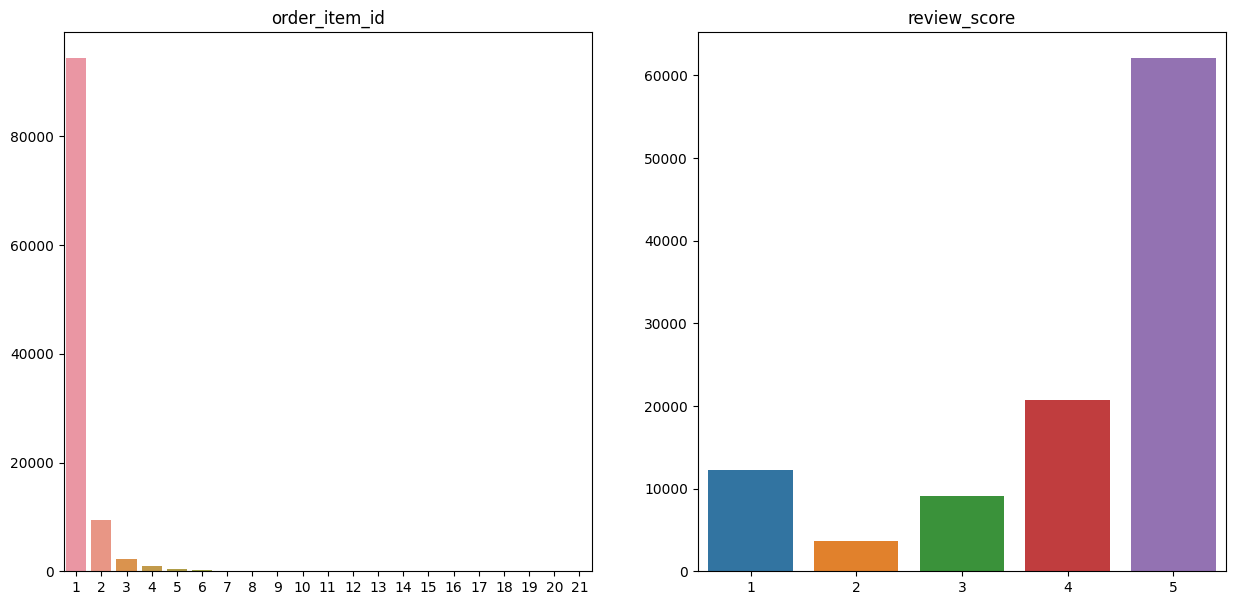

In [485]:
int_cols = transactions_df.loc[:, transactions_df.dtypes == "int64"]

fig = plt.figure(figsize=(15,7))
fig.subplots_adjust(hspace=0.3)

for i, col in enumerate(int_cols):
    plt.subplot(1,2,i+1, label=col)
    int_frequency = transactions_df[col].value_counts()
    sns.barplot(x=int_frequency.index, y=int_frequency.values)
    plt.title(col)

#### Checking numerical columns (outlier detection)

In [486]:
float_cols = transactions_df.loc[:, transactions_df.dtypes == "float64"]

fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.3)

for i, col in enumerate(float_cols):
    plt.subplot(3,3,i+1, label=col)
    sns.boxplot(data=transactions_df, x=col)
    plt.title(col)

#### Checking datetime columns

In [487]:
datetime_cols = transactions_df.loc[:, transactions_df.dtypes == "datetime64[ns]"]

fig = plt.figure(figsize=(30,10))
fig.subplots_adjust(hspace=0.3)

for i, col in enumerate(datetime_cols):
    plt.subplot(2,4,i+1, label=col)
    sns.histplot(data=transactions_df, x=col)
    plt.title(col)

### Feature engineering

#### Feature selection

In [488]:
relevant_features = ['product_id',
                     'price',
                     'order_purchase_timestamp',
                     'review_score',
                     'product_weight_g',
                     'product_length_cm',
                     'product_height_cm',
                     'product_width_cm',
                     'product_category_name_english',
                     ]

Why are the others deemed irrelevant? yung mga ibang dates can be useful when optimizing price for freight but that's not what we're doing naman

In [489]:
main_df = transactions_df.copy()
main_df = main_df[relevant_features]
main_df.sample(5)

product_id   price order_purchase_timestamp  \
11312   0bcc3eeca39e1064258aa1e932269894   59.90      2017-09-30 10:28:45   
15738   cd48f265a63e13b762601f5f794c5fca   47.49      2018-02-15 21:07:30   
1443    c6dd917a0be2a704582055949915ab32   99.99      2017-04-15 22:00:21   
102740  6ca54e191592a843087a042b0665d7ef  189.00      2018-08-01 19:40:51   
18835   a94036c0bb4dfce8d5762777c07b7be2  124.90      2017-10-16 20:05:03   

        review_score  product_weight_g  product_length_cm  product_height_cm  \
11312              4            1800.0               37.0               22.0   
15738              3             175.0               23.0               21.0   
1443               1            1200.0               42.0               25.0   
102740             5            2200.0               55.0                5.0   
18835              5            2500.0               43.0                8.0   

        product_width_cm product_category_name_english  
11312               40.0                  garden_tools  
15738               21.0                        drinks  
1443                15.0                    cool_stuff  
102740             100.0               furniture_decor  
18835               33.0                bed_bath_table

#### Feature generation

In [490]:
main_df["day_of_week"] = main_df["order_purchase_timestamp"].dt.day_of_week
main_df["is_weekday"] = main_df["day_of_week"] < 5
main_df["month"] = main_df["order_purchase_timestamp"].dt.month
main_df["year"] = main_df["order_purchase_timestamp"].dt.year
main_df["hour"] = main_df["order_purchase_timestamp"].dt.hour
main_df["date_purchased"] = pd.to_datetime(main_df["order_purchase_timestamp"].dt.date)
main_df.sample(5)

product_id    price order_purchase_timestamp  \
75221  efa91c03c750cf82e0e9fc5523aca73c    73.35      2017-11-24 17:56:30   
23815  25292482a61cb3298df8dbe15ea69daf  1149.65      2018-04-13 18:37:38   
73263  42faf2e98f0486405f5dfac48e5cba7d    14.46      2017-12-23 22:42:51   
74746  0ecaf0629e5e227413504f3892bd76ba    89.90      2018-04-21 19:50:43   
64285  fbb72ae209733219a1a5019715b15472    99.99      2018-08-13 17:23:09   

       review_score  product_weight_g  product_length_cm  product_height_cm  \
75221             5            1000.0               31.0               11.0   
23815             5             500.0               24.0                6.0   
73263             4             100.0               16.0                2.0   
74746             1            3800.0               45.0               15.0   
64285             2            1300.0               22.0               22.0   

       product_width_cm product_category_name_english  day_of_week  \
75221              26.0               furniture_decor            4   
23815              12.0                 health_beauty            4   
73263              20.0                  garden_tools            5   
74746              35.0                  home_confort            5   
64285              22.0     construction_tools_lights            0   

       is_weekday  month  year  hour date_purchased  
75221        True     11  2017    17     2017-11-24  
23815        True      4  2018    18     2018-04-13  
73263       False     12  2017    22     2017-12-23  
74746       False      4  2018    19     2018-04-21  
64285        True      8  2018    17     2018-08-13

In [491]:
main_df["product_volume_cm3"] = main_df["product_length_cm"] * main_df["product_width_cm"] * main_df["product_height_cm"]
main_df.sample(5)

product_id   price order_purchase_timestamp  \
25388   e5ae72c62ebfa708624f5029d609b160   61.90      2017-06-25 19:51:10   
41697   4a5c3967bfd3629fe07ef4d0cc8c3818   99.90      2017-12-20 13:29:07   
42726   1c4de4dd53a801716c8a3a2cf51f35fa  149.00      2017-07-19 02:59:17   
93143   60a82b9f55ecd2035ad8d9c61e2afe18   25.50      2017-10-20 19:08:24   
105356  0a6cf067b01351046739940c8cb7f60f   36.75      2017-01-26 21:33:43   

        review_score  product_weight_g  product_length_cm  product_height_cm  \
25388              5             156.0               18.0               12.0   
41697              5            2750.0               25.0                8.0   
42726              5             300.0               16.0                2.0   
93143              5             200.0               32.0                3.0   
105356             4             600.0               26.0               13.0   

        product_width_cm    product_category_name_english  day_of_week  \
25388               15.0            computers_accessories            6   
41697               25.0  construction_tools_construction            2   
42726               11.0                    watches_gifts            2   
93143               23.0                   bed_bath_table            4   
105356              41.0                             toys            3   

        is_weekday  month  year  hour date_purchased  product_volume_cm3  
25388        False      6  2017    19     2017-06-25              3240.0  
41697         True     12  2017    13     2017-12-20              5000.0  
42726         True      7  2017     2     2017-07-19               352.0  
93143         True     10  2017    19     2017-10-20              2208.0  
105356        True      1  2017    21     2017-01-26             13858.0

### Final diagnosis of main_df

In [492]:
main_df.sample(5)

product_id   price order_purchase_timestamp  \
3881    601a360bd2a916ecef0e88de72a6531a  129.99      2017-05-18 16:27:03   
104355  0dce4d890959f0607b58e7475d13fc86   35.70      2017-11-09 19:18:12   
11715   422879e10f46682990de24d770e7f83d   49.00      2017-11-25 10:53:05   
25953   16ed6a6e3fce23b741650437fe58d65b   89.18      2018-02-27 13:13:59   
76567   f9a09e5ecddf77ede4cade6a11624ac9  419.90      2018-01-31 14:16:10   

        review_score  product_weight_g  product_length_cm  product_height_cm  \
3881               5            1600.0               42.0               25.0   
104355             3             600.0               20.0                8.0   
11715              5            1550.0               30.0               22.0   
25953              3             750.0               35.0               15.0   
76567              5           20500.0               58.0               28.0   

        product_width_cm product_category_name_english  day_of_week  \
3881                15.0                    cool_stuff            3   
104355              13.0                 health_beauty            3   
11715               30.0                  garden_tools            5   
25953               35.0                    housewares            1   
76567               58.0              office_furniture            2   

        is_weekday  month  year  hour date_purchased  product_volume_cm3  
3881          True      5  2017    16     2017-05-18             15750.0  
104355        True     11  2017    19     2017-11-09              2080.0  
11715        False     11  2017    10     2017-11-25             19800.0  
25953         True      2  2018    13     2018-02-27             18375.0  
76567         True      1  2018    14     2018-01-31             94192.0

In [493]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107806 entries, 0 to 110749
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   product_id                     107806 non-null  object        
 1   price                          107806 non-null  float64       
 2   order_purchase_timestamp       107806 non-null  datetime64[ns]
 3   review_score                   107806 non-null  int64         
 4   product_weight_g               107806 non-null  float64       
 5   product_length_cm              107806 non-null  float64       
 6   product_height_cm              107806 non-null  float64       
 7   product_width_cm               107806 non-null  float64       
 8   product_category_name_english  107806 non-null  object        
 9   day_of_week                    107806 non-null  int64         
 10  is_weekday                     107806 non-null  bool          
 11  

In [494]:
main_row, main_col = main_df.shape

print(f"main_df has a total of {main_row} entries and {main_col} features.")

main_df has a total of 107806 entries and 16 features.


## Exploratory Data Analysis (EDA)

### Sampling for our dataset

In [495]:
sampled_df = main_df.copy()
sampled_df = sampled_df.sample(frac=.2, random_state=25)
sampled_df

product_id   price order_purchase_timestamp  \
69574   113f80f12c8892f0c59206f70b862b40   19.90      2018-07-14 09:47:09   
109365  367f4a5ae70f2e8de8d9eb1c13f280b1    9.00      2017-05-26 15:53:43   
10626   19c91ef95d509ea33eda93495c4d3481  122.99      2018-08-07 20:27:57   
79627   6cbe4bd19efc4606eb2a9448a47e232e   38.90      2018-02-15 10:03:54   
44343   704ef63ad0ac345842ea734060a83db2   74.90      2018-01-12 18:43:34   
...                                  ...     ...                      ...   
17383   f5badee8a0e679f057ec0ca4f0f32dcb  109.90      2017-11-25 09:20:17   
43099   85337022853da10b8f5fd7d1ef180421   39.90      2017-08-27 14:11:40   
31246   ce4951e4e9e73626368438f1dbc05dd2   33.00      2018-02-26 14:31:31   
42027   65266b2da20d04dbe00c5c2d3bb7859e   23.90      2018-05-14 14:36:06   
26724   77d1b9fb8d3858f503316105e9ac6c51   18.99      2018-04-23 00:34:50   

        review_score  product_weight_g  product_length_cm  product_height_cm  \
69574              5             250.0               16.0               10.0   
109365             5            1950.0               20.0                6.0   
10626              4             700.0               25.0               12.0   
79627              4             300.0               30.0               20.0   
44343              4             850.0               38.0               10.0   
...              ...               ...                ...                ...   
17383              5             450.0               20.0               10.0   
43099              2             200.0               25.0                5.0   
31246              5             400.0               16.0               23.0   
42027              5             250.0               51.0               15.0   
26724              2              50.0               19.0                3.0   

        product_width_cm    product_category_name_english  day_of_week  \
69574               16.0                   bed_bath_table            5   
109365              20.0                   sports_leisure            4   
10626               19.0                    health_beauty            1   
79627               20.0                   consoles_games            3   
44343               38.0                   bed_bath_table            4   
...                  ...                              ...          ...   
17383               15.0  construction_tools_construction            5   
43099               15.0                   consoles_games            6   
31246               11.0                  books_technical            0   
42027               15.0                       stationery            0   
26724               11.0                        telephony            0   

        is_weekday  month  year  hour date_purchased  product_volume_cm3  
69574        False      7  2018     9     2018-07-14              2560.0  
109365        True      5  2017    15     2017-05-26              2400.0  
10626         True      8  2018    20     2018-08-07              5700.0  
79627         True      2  2018    10     2018-02-15             12000.0  
44343         True      1  2018    18     2018-01-12             14440.0  
...            ...    ...   ...   ...            ...                 ...  
17383        False     11  2017     9     2017-11-25              3000.0  
43099        False      8  2017    14     2017-08-27              1875.0  
31246         True      2  2018    14     2018-02-26              4048.0  
42027         True      5  2018    14     2018-05-14             11475.0  
26724         True      4  2018     0     2018-04-23               627.0  

[21561 rows x 16 columns]

### Checking out distribution of features

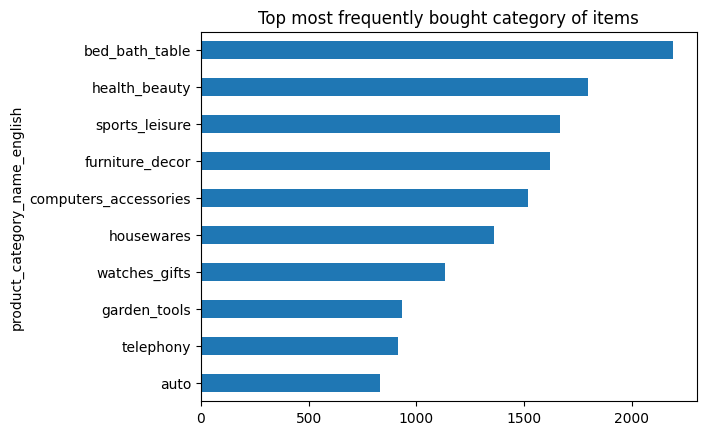

In [496]:
(sampled_df
 .groupby("product_category_name_english")["product_id"]
 .count()
 .sort_values(ascending=False)
 .head(10)
 .plot
 .barh(title="Top most frequently bought category of items")
 .invert_yaxis()
 )

<Axes: title={'center': 'Distribution of review scores'}>

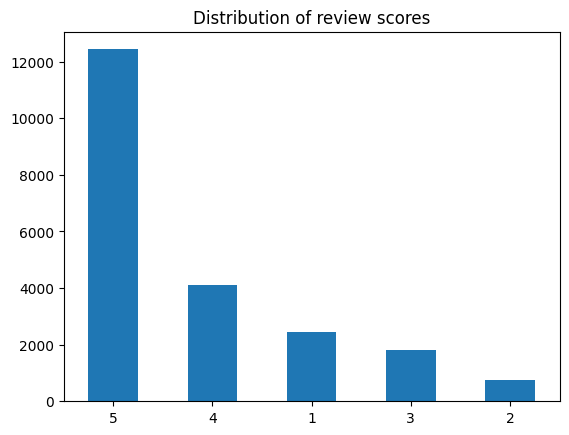

In [497]:
(sampled_df
 .review_score
 .value_counts()
 .plot
 .bar(rot=0,
      title="Distribution of review scores"))

<Axes: title={'center': 'Distribution of purchases made in each year'}>

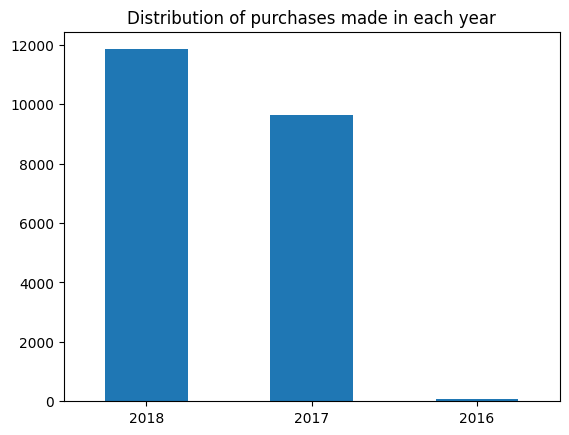

In [498]:
(sampled_df
 .year
 .value_counts()
 .plot
 .bar(rot=0,
       title="Distribution of purchases made in each year"))

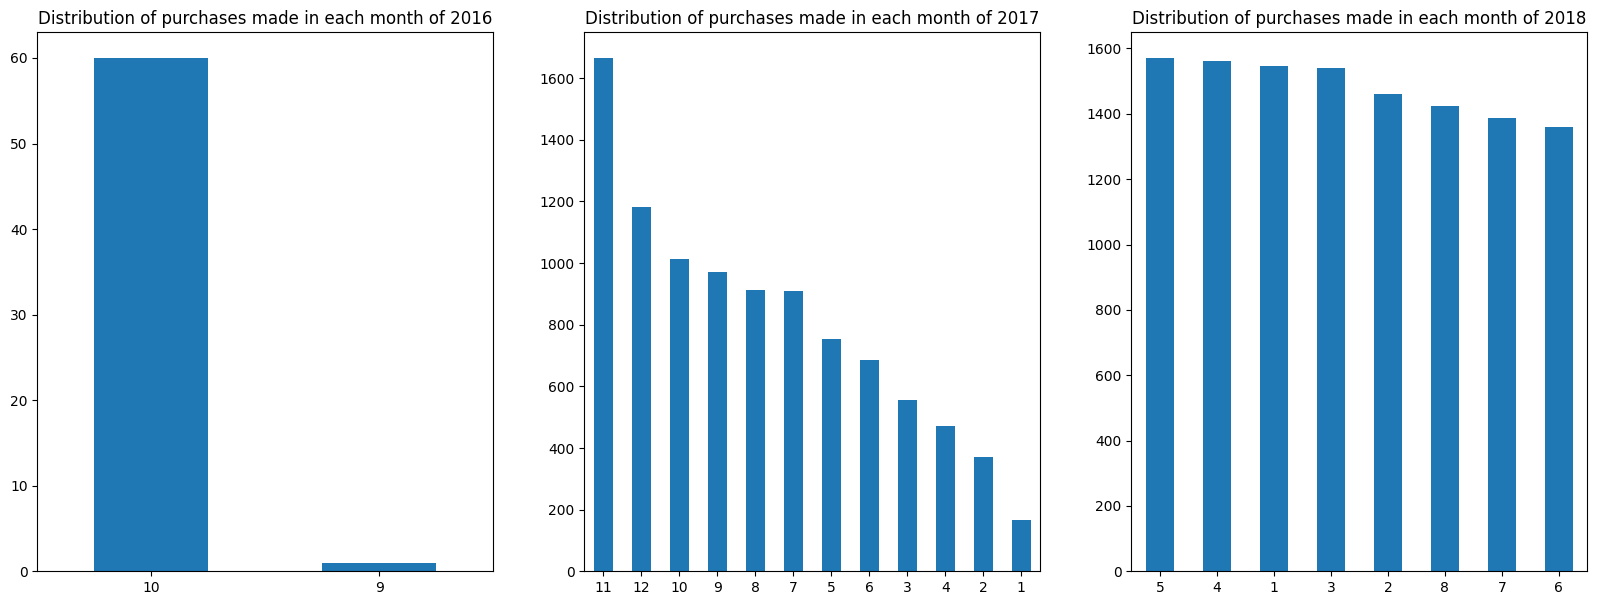

In [499]:
fig, ax = plt.subplots(1,3, figsize=(20,7))

years = sampled_df.year.sort_values().unique()

for i, year in enumerate(years):
    (sampled_df
    .query("year == @year")
    .month
    .value_counts()
    .plot
    .bar(rot=0,
        title=f"Distribution of purchases made in each month of {year}",
        ax=ax[i])
    )

Text(0.5, 0, '[0] Monday - [6] Sunday')

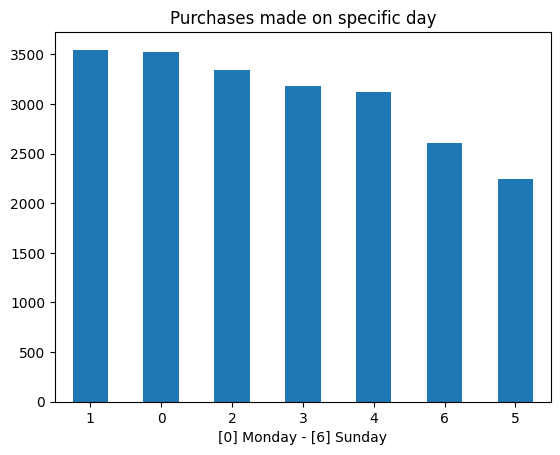

In [500]:
(sampled_df
 .day_of_week.
 value_counts()
 .plot
 .bar(rot=0,
      title="Purchases made on specific day"
      )
 )
plt.xlabel("[0] Monday - [6] Sunday")

<Axes: title={'center': 'Purchase made on a weekday?'}>

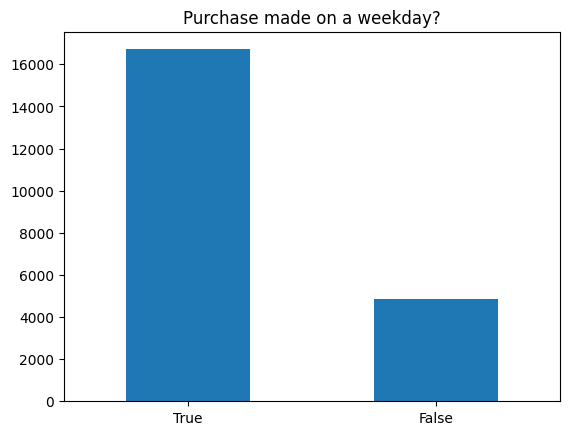

In [501]:
(sampled_df
 .is_weekday
 .value_counts()
 .plot
 .bar(rot=0,
      title="Purchase made on a weekday?")
 )

<Axes: title={'center': 'Distribution of Purchases by hour in a day'}, ylabel='Frequency'>

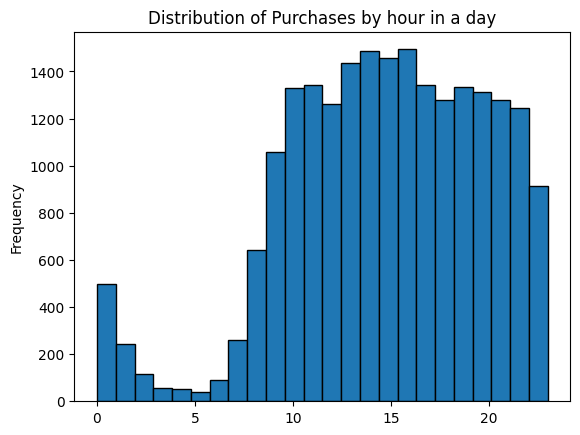

In [502]:
(sampled_df
 .hour
 .plot
 .hist(bins=24,edgecolor="black", title="Distribution of Purchases by hour in a day"))

Text(0.5, 1.0, 'Frequency of transactions per day from 2016-2018')

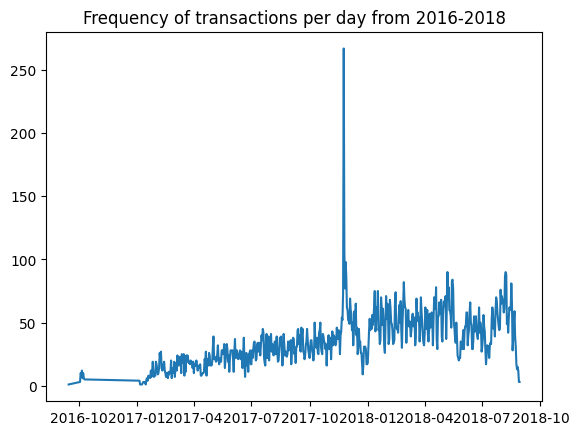

In [503]:
purchase_freq_date = sampled_df.date_purchased.value_counts().sort_index()
plt.plot(purchase_freq_date.index, purchase_freq_date.values)
plt.title("Frequency of transactions per day from 2016-2018")

<Axes: title={'center': 'Frequency of transactions per month from 2016-2018'}, xlabel='date_purchased'>

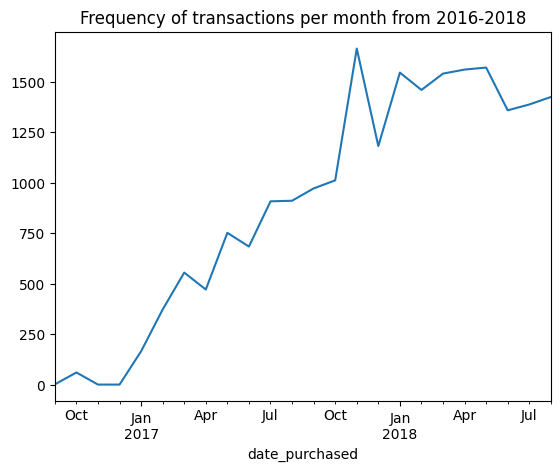

In [504]:
sampled_df.groupby(pd.Grouper(key="date_purchased", freq="M"))["product_id"].count().plot.line(title="Frequency of transactions per month from 2016-2018")

## Regression Trees for Price Optimization

### Creating dummy variables

In [505]:
#  adopting the sampled dataset
main_df = sampled_df

label_encoder = LabelEncoder()

main_df["product_category_name_english"] = label_encoder.fit_transform(main_df["product_category_name_english"])
main_df['is_weekday'] = label_encoder.fit_transform(main_df["is_weekday"])

main_df

product_id   price order_purchase_timestamp  \
69574   113f80f12c8892f0c59206f70b862b40   19.90      2018-07-14 09:47:09   
109365  367f4a5ae70f2e8de8d9eb1c13f280b1    9.00      2017-05-26 15:53:43   
10626   19c91ef95d509ea33eda93495c4d3481  122.99      2018-08-07 20:27:57   
79627   6cbe4bd19efc4606eb2a9448a47e232e   38.90      2018-02-15 10:03:54   
44343   704ef63ad0ac345842ea734060a83db2   74.90      2018-01-12 18:43:34   
...                                  ...     ...                      ...   
17383   f5badee8a0e679f057ec0ca4f0f32dcb  109.90      2017-11-25 09:20:17   
43099   85337022853da10b8f5fd7d1ef180421   39.90      2017-08-27 14:11:40   
31246   ce4951e4e9e73626368438f1dbc05dd2   33.00      2018-02-26 14:31:31   
42027   65266b2da20d04dbe00c5c2d3bb7859e   23.90      2018-05-14 14:36:06   
26724   77d1b9fb8d3858f503316105e9ac6c51   18.99      2018-04-23 00:34:50   

        review_score  product_weight_g  product_length_cm  product_height_cm  \
69574              5             250.0               16.0               10.0   
109365             5            1950.0               20.0                6.0   
10626              4             700.0               25.0               12.0   
79627              4             300.0               30.0               20.0   
44343              4             850.0               38.0               10.0   
...              ...               ...                ...                ...   
17383              5             450.0               20.0               10.0   
43099              2             200.0               25.0                5.0   
31246              5             400.0               16.0               23.0   
42027              5             250.0               51.0               15.0   
26724              2              50.0               19.0                3.0   

        product_width_cm  product_category_name_english  day_of_week  \
69574               16.0                              7            5   
109365              20.0                             64            4   
10626               19.0                             43            1   
79627               20.0                             16            3   
44343               38.0                              7            4   
...                  ...                            ...          ...   
17383               15.0                             17            5   
43099               15.0                             16            6   
31246               11.0                             10            0   
42027               15.0                             65            0   
26724               11.0                             67            0   

        is_weekday  month  year  hour date_purchased  product_volume_cm3  
69574            0      7  2018     9     2018-07-14              2560.0  
109365           1      5  2017    15     2017-05-26              2400.0  
10626            1      8  2018    20     2018-08-07              5700.0  
79627            1      2  2018    10     2018-02-15             12000.0  
44343            1      1  2018    18     2018-01-12             14440.0  
...            ...    ...   ...   ...            ...                 ...  
17383            0     11  2017     9     2017-11-25              3000.0  
43099            0      8  2017    14     2017-08-27              1875.0  
31246            1      2  2018    14     2018-02-26              4048.0  
42027            1      5  2018    14     2018-05-14             11475.0  
26724            1      4  2018     0     2018-04-23               627.0  

[21561 rows x 16 columns]

### Converting non-integers, non-string, and non-datetime columns to integer

We need to convert our floats into int in order to build a decision tree model

In [506]:
non_int_cols = main_df.loc[:, (main_df.dtypes != "int64") & (main_df.dtypes != "datetime64[ns]") & (main_df.dtypes != "object")].columns

for cols in non_int_cols:
    main_df[cols] = main_df[cols].astype("int64")
    
main_df.dtypes

product_id                               object
price                                     int64
order_purchase_timestamp         datetime64[ns]
review_score                              int64
product_weight_g                          int64
product_length_cm                         int64
product_height_cm                         int64
product_width_cm                          int64
product_category_name_english             int64
day_of_week                               int64
is_weekday                                int64
month                                     int64
year                                      int64
hour                                      int64
date_purchased                   datetime64[ns]
product_volume_cm3                        int64
dtype: object

### Selecting features

#### Correlation heatmap

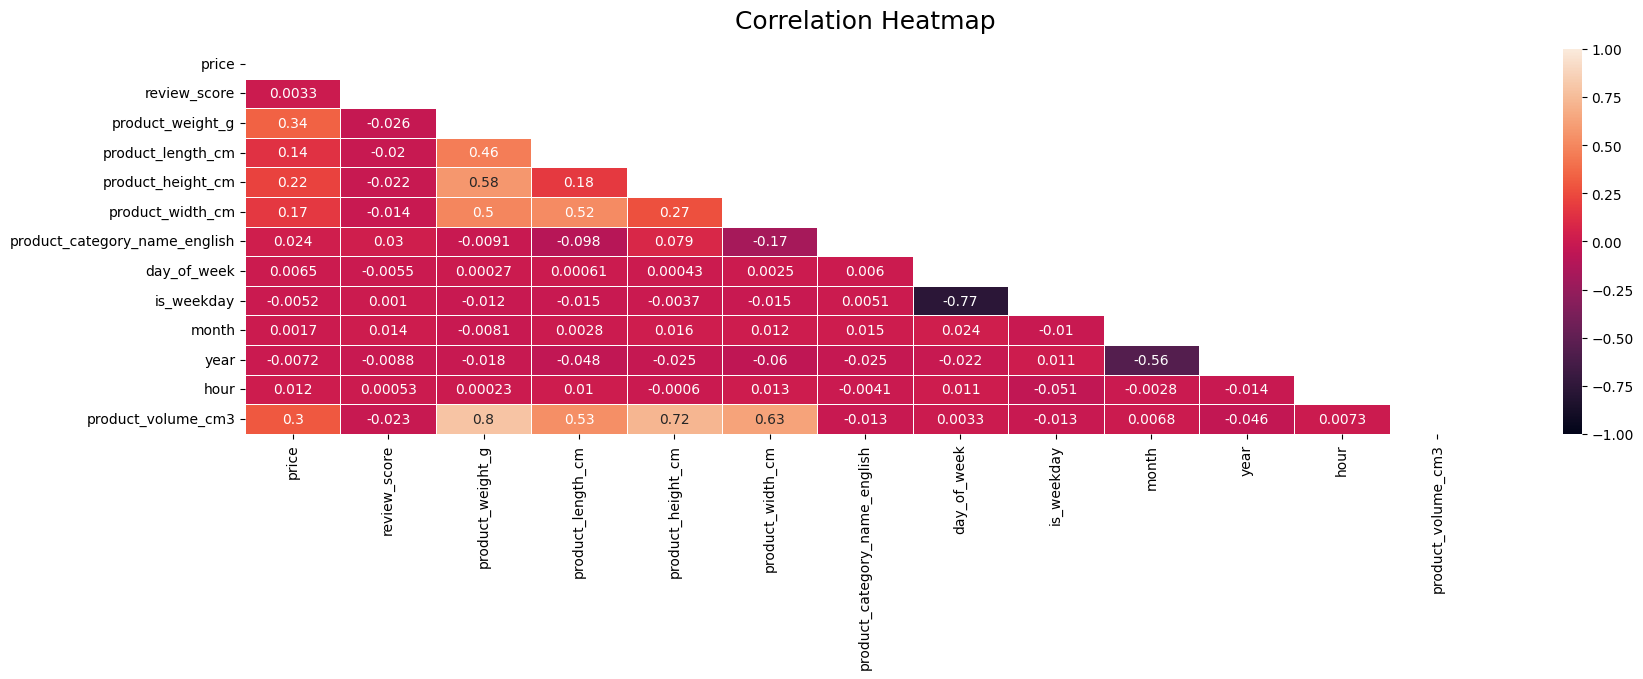

In [507]:
mask = np.triu(np.ones_like(main_df.corr(numeric_only=True)))
corr = main_df.corr(numeric_only=True)

plt.figure(figsize=(20, 5))
sns.heatmap(corr,
            mask=mask, 
            annot=True, 
            vmin=-1,
            vmax=1,
            linewidths=.5)
plt.title('Correlation Heatmap', fontdict={'fontsize': 18}, pad=15);

#### Filtering main dataset with positively correlated features

In [508]:
correlated_features = ["price",
                       "product_weight_g",
                       "product_length_cm",
                       "product_height_cm",
                       "product_width_cm",
                       "product_volume_cm3"]

main_df = main_df[correlated_features]

### Splitting main dataset

In [509]:
#  split dataset in features and target variables
feature_cols = main_df.loc[:, main_df.dtypes == "int64"].columns

X, y = main_df[feature_cols[1:]], main_df[feature_cols[0]]

In [510]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

### Building Decision Tree Model

In [511]:
# # Create Decision Tree classifer object
# clf = DecisionTreeClassifier()

# # Train Decision Tree Classifer
# clf = clf.fit(X_train,y_train)

# #Predict the response for test dataset
# y_pred = clf.predict(X_test)

In [512]:
# Create Decision Tree Regressor
reg_tree = DecisionTreeRegressor(random_state=42)

# Train Decision Tree Regressor
reg_tree = reg_tree.fit(X_train,y_train)

#  Evaluating the reg_tree 
train_pred = reg_tree.predict(X_train)
train_score = reg_tree.score(X_train, y_train)
train_mse = mean_squared_error(y_train, train_pred)
print("Training Set Scores")
print(f"MSE: {train_mse}")
print(f"RMSE: {train_mse**(1/2)}")
print(f"R-square: {train_score}")

Training Set Scores
MSE: 1302.2733824761867
RMSE: 36.08702512643826
R-square: 0.9623025579747616


### Evaluating the Initial Model

In [513]:
#  Evaluating the reg_tree 
test_pred = reg_tree.predict(X_test)
test_score = reg_tree.score(X_test, y_test)
test_mse = mean_squared_error(y_test, test_pred)
print("Testing Set Scores")
print(f"MSE: {test_mse}")
print(f"RMSE: {test_mse**(1/2)}")
print(f"R-square: {test_score}")

Testing Set Scores
MSE: 36276.277067035066
RMSE: 190.46332210437544
R-square: 0.19127465986056646


In [514]:
# # Model Accuracy, how often is the classifier correct
# print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

### Hyperparameter tuning

In [515]:
param_grid = {"criterion": ["squared_error", "absolute_error", "poisson"],
              "splitter":  ["best", "random"],
              "max_features": ["sqrt", "log2"],
              "min_samples_leaf": range(2,11),
              "max_depth": range(5,21)
              }

#### Using GridSearchCV

In [516]:
reg_tree_gs = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(estimator=reg_tree_gs, 
                           param_grid=param_grid,
                           verbose=3,
                           return_train_score=True)
grid_search = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
[CV 1/5] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best;, score=(train=0.236, test=0.070) total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best;, score=(train=0.220, test=0.046) total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best;, score=(train=0.227, test=0.130) total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best;, score=(train=0.216, test=0.100) total time=   0.0s
[CV 5/5] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best;, score=(train=0.234, test=0.092) total time=   0.0s
[CV 1/5] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random;, score=(train=0.141, test=0.121) total time

In [520]:
best_params_gs = grid_search.best_params_
best_regtree_gs = DecisionTreeRegressor(criterion=best_params_gs["criterion"],
                                        max_features=best_params_gs["max_features"],
                                        min_samples_leaf=best_params_gs["min_samples_leaf"],
                                        splitter=best_params_gs["splitter"],
                                        random_state=42)

best_regtree_gs = best_regtree_gs.fit(X_train, y_train)

training_score = best_regtree_gs.score(X_train, y_train)

print(best_params_gs)

#  Evaluating the train set with best_regtree_gs 
train_pred = best_regtree_gs.predict(X_train)
train_score = best_regtree_gs.score(X_train, y_train)
train_mse = mean_squared_error(y_train, train_pred)
print("Training Set Scores")
print(f"MSE: {train_mse}")
print(f"RMSE: {train_mse**(1/2)}")
print(f"R-square: {train_score}\n")

#  Evaluating the test set with best_regtree_gs 
test_pred = best_regtree_gs.predict(X_test)
test_score = best_regtree_gs.score(X_test, y_test)
test_mse = mean_squared_error(y_test, test_pred)
print("Testing Set Scores")
print(f"MSE: {test_mse}")
print(f"RMSE: {test_mse**(1/2)}")
print(f"R-square: {test_score}")


{'criterion': 'absolute_error', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'splitter': 'best'}
Training Set Scores
MSE: 23857.631758547574
RMSE: 154.45915886909256
R-square: 0.3093833428682714

Testing Set Scores
MSE: 36743.1921471634
RMSE: 191.6851380445636
R-square: 0.18086548649651835


#### Using RandomizedSearchCV

In [521]:
reg_tree_rs = DecisionTreeRegressor(random_state=42)
random_search = RandomizedSearchCV(estimator=reg_tree_rs, 
                                   param_distributions=param_grid,
                                   verbose=3,
                                   return_train_score=True)
random_search = random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END criterion=absolute_error, max_depth=6, max_features=log2, min_samples_leaf=9, splitter=best;, score=(train=0.146, test=0.114) total time=   0.8s
[CV 2/5] END criterion=absolute_error, max_depth=6, max_features=log2, min_samples_leaf=9, splitter=best;, score=(train=0.137, test=0.137) total time=   0.8s
[CV 3/5] END criterion=absolute_error, max_depth=6, max_features=log2, min_samples_leaf=9, splitter=best;, score=(train=0.155, test=0.113) total time=   0.8s
[CV 4/5] END criterion=absolute_error, max_depth=6, max_features=log2, min_samples_leaf=9, splitter=best;, score=(train=0.117, test=0.098) total time=   0.8s
[CV 5/5] END criterion=absolute_error, max_depth=6, max_features=log2, min_samples_leaf=9, splitter=best;, score=(train=0.153, test=0.164) total time=   0.8s
[CV 1/5] END criterion=poisson, max_depth=13, max_features=log2, min_samples_leaf=2, splitter=random;, score=(train=0.324, test=0.086) total time=   

In [522]:
best_params_rs = random_search.best_params_
best_regtree_rs = DecisionTreeRegressor(criterion=best_params_rs["criterion"],
                                        max_features=best_params_rs["max_features"],
                                        min_samples_leaf=best_params_rs["min_samples_leaf"],
                                        splitter=best_params_rs["splitter"],
                                        random_state=42)

best_regtree_rs = best_regtree_rs.fit(X_train, y_train)

training_score = best_regtree_rs.score(X_train, y_train)

print(best_params_rs)

#  Evaluating the train set with best_regtree_rs 
train_pred = best_regtree_rs.predict(X_train)
train_score = best_regtree_rs.score(X_train, y_train)
train_mse = mean_squared_error(y_train, train_pred)
print("Training Set Scores")
print(f"MSE: {train_mse}")
print(f"RMSE: {train_mse**(1/2)}")
print(f"R-square: {train_score}\n")

#  Evaluating the test set with best_regtree_rs 
test_pred = best_regtree_rs.predict(X_test)
test_score = best_regtree_rs.score(X_test, y_test)
test_mse = mean_squared_error(y_test, test_pred)
print("Testing Set Scores")
print(f"MSE: {test_mse}")
print(f"RMSE: {test_mse**(1/2)}")
print(f"R-square: {test_score}")


{'splitter': 'best', 'min_samples_leaf': 7, 'max_features': 'log2', 'max_depth': 9, 'criterion': 'squared_error'}
Training Set Scores
MSE: 19627.59442753705
RMSE: 140.09851686415902
R-square: 0.43183196939794655

Testing Set Scores
MSE: 37043.81548920154
RMSE: 192.4676998594869
R-square: 0.17416353871686108


## Visualizing Decision Trees

For plotting the tree, you also need to install graphviz, pydotplus and six

`pip install graphviz`\
`pip install pydotplus`\
`pip install six`

In [118]:
# importing additional libraries
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import six
import sys
sys.modules['sklearn.externals.six'] = six
from IPython.display import Image  
import pydotplus
from six import StringIO

In [119]:
dot_data = StringIO()
export_graphviz(clf, 
                out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('price.png')
Image(graph.create_png())

ValueError: Length of feature_names, 13 does not match number of features, 12

[Text(0.47924679136987086, 0.9912280701754386, 'product_weight_g <= 359.0\ngini = 0.988\nsamples = 107806\nvalue = [3, 20, 4 ... 1, 1, 1]'),
 Text(0.1593573080487158, 0.9736842105263158, 'product_volume_cm3 <= 1912.5\ngini = 0.981\nsamples = 34908\nvalue = [3, 0, 4 ... 0, 0, 0]'),
 Text(0.12389728099124515, 0.956140350877193, 'product_length_cm <= 21.5\ngini = 0.967\nsamples = 12765\nvalue = [3, 0, 3 ... 0, 0, 0]'),
 Text(0.09666556132674313, 0.9385964912280702, 'product_width_cm <= 19.5\ngini = 0.964\nsamples = 11569\nvalue = [3, 0, 2 ... 0, 0, 0]'),
 Text(0.050681183601387826, 0.9210526315789473, 'product_volume_cm3 <= 363.0\ngini = 0.962\nsamples = 9918\nvalue = [3, 0, 2 ... 0, 0, 0]'),
 Text(0.010806848288846425, 0.9035087719298246, 'product_weight_g <= 245.0\ngini = 0.904\nsamples = 1372\nvalue = [0, 0, 1 ... 0, 0, 0]'),
 Text(0.0031925273738174927, 0.8859649122807017, 'product_weight_g <= 187.5\ngini = 0.911\nsamples = 711\nvalue = [0, 0, 1 ... 0, 0, 0]'),
 Text(0.000644274689916

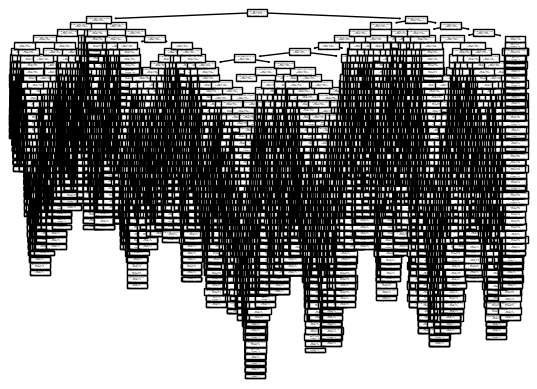

In [54]:
dtree=DecisionTreeClassifier()
dtree=dtree.fit(X,y)

tree.plot_tree(dtree, feature_names=feature_cols)

since the decision trees are not really that comprehensive, let us get the variables that are highly correlated to the reponse variable

In [82]:
feature_cols_new=['product_weight_g', 'product_length_cm', 'product_height_cm']
X_new=new_df[feature_cols_new]
y_new=new_df.price

In [83]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.3, random_state=1) # 70% training and 30% test

In [84]:
# Create Decision Tree classifer object
clfn = DecisionTreeClassifier()

# Train Decision Tree Classifer
clfn = clfn.fit(X_train_new,y_train_new)

#Predict the response for test dataset
y_pred_new = clfn.predict(X_test_new)

In [80]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test_new, y_pred_new))

Accuracy: 0.5167274751097644



(process:3844): GLib-GIO-WARNING **: 21:34:45.333: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.5.15.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs

(process:3844): GLib-GIO-WARNING **: 21:34:45.541: Unexpectedly, UWP app `Microsoft.ScreenSketch_11.2302.20.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.ScreenSketch_8wekyb3d8bbwe!App') supports 29 extensions but has no verbs
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0183874 to fit


(process:16260): GLib-GIO-WARNING **: 21:42:55.796: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.5.15.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs

(process:16260): GLib-GIO-WARNING **: 21:42:55.922: Unexpectedly, UWP app `Microsoft.ScreenSketch_11.2302.20.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.ScreenSketch_8wekyb3d8bbwe!App') supports 29 extensions but has no verbs
dot: graph is too large for cairo-rendere

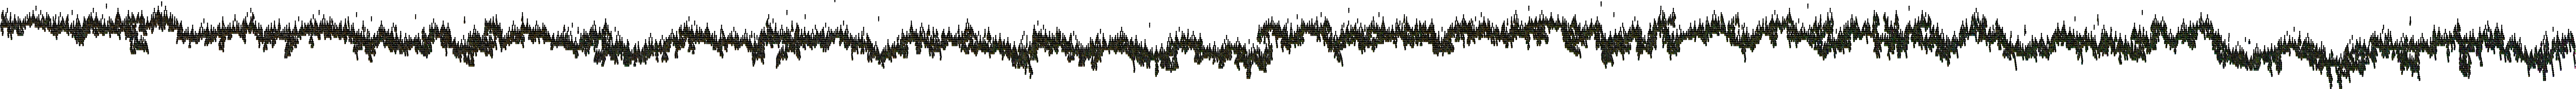

In [85]:
dot_data= StringIO()
export_graphviz(clfn, out_file=dot_data, 
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols_new ,class_names=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('price_new.png')
Image(graph.create_png())

In [86]:
dtree_new=DecisionTreeClassifier()
dtree_new=dtree_new.fit(X_train_new,y_train_new)

tree.plot_tree(dtree_new, feature_names=feature_cols_new)

[Text(0.3514017565195753, 0.9883720930232558, 'product_weight_g <= 350.5\ngini = 0.988\nsamples = 75464\nvalue = [2, 13, 3, 21, 30, 73, 90, 132, 116, 296, 224\n184, 556, 497, 552, 451, 442, 417, 692, 1448, 284\n476, 437, 461, 1122, 555, 367, 674, 491, 2375, 283\n353, 443, 202, 917, 866, 269, 358, 613, 1833, 361\n198, 356, 286, 667, 901, 213, 366, 429, 2810, 332\n169, 286, 583, 519, 569, 654, 221, 421, 2651, 173\n147, 159, 125, 463, 457, 190, 226, 228, 2116, 190\n91, 265, 95, 407, 445, 167, 131, 339, 1773, 152\n116, 143, 110, 515, 284, 180, 134, 170, 2078, 142\n78, 128, 139, 241, 309, 111, 187, 268, 2222, 147\n51, 100, 103, 249, 332, 99, 140, 184, 916, 544, 26\n113, 144, 189, 231, 178, 168, 192, 1195, 429, 56\n128, 39, 198, 180, 91, 119, 91, 1169, 146, 44, 59\n57, 201, 225, 51, 69, 143, 838, 108, 26, 52, 120\n214, 149, 106, 52, 147, 1215, 225, 53, 70, 39, 78\n120, 49, 69, 86, 646, 107, 30, 19, 31, 66, 74\n93, 52, 76, 673, 118, 23, 20, 46, 89, 117, 47\n57, 61, 707, 122, 19, 25, 12, 56, 8

## Optimizing Decision Tree Performance

In [87]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.06298311792715354


Based on this, we can optimize the decision tree performance

Note: You will see that the Decision Tree gives you different results if you run it enough times, even if you feed it with the same data.\
That is because the Decision Tree does not give us a 100% certain answer. It is based on the probability of an outcome, and the answer will vary.\
Thus, bootstrapping is useless in this point